In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
from scipy import stats
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
price_house = pd.read_csv('C:\\Users\\Lor\\Desktop\\Master\\TFM\\01_data\\00_data_clean\\historico_madrid_limpio.csv')

In [65]:
price_house.shape

(75982, 18)

In [5]:
#añado una columna para poder tener el año y poder separar el dataset

price_house["year"] = pd.to_datetime(price_house["Fecha"],format="%Y-%m-%d").dt.year

In [6]:
# Hold-out. Separo los datos de entrenamiento y test por fechas. Es lo más lógico para datos temporales
train = price_house[price_house["Fecha"]<"2018"]
test = price_house[price_house["Fecha"]>="2018"]

In [7]:
#leemos train y eliminamos las columnas que se han creado anteriormente
train.columns.values
train.drop(['Unnamed: 0'], axis='columns', inplace=True)
train.head()

C:\Users\Lor\Anaconda\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Fecha,price,postal_code,cod_distrito,size,bedrooms,bathrooms,price_m2,lift,swimming_pool,garden,sports,status,air_conditioning,construction_year,exterior,year
0,2002-11-14,138232.0,28011,10,70.0,2,1,1974.7429,1,0,0,0,2,0,1972,0,2002
1,2003-01-22,195349.0,28041,12,84.0,2,2,2325.5833,1,1,1,1,2,0,1999,0,2003
2,2003-02-21,140740.0,28030,14,60.0,3,1,2345.6667,1,0,0,0,2,0,1973,0,2003
3,2003-03-10,167000.0,28011,10,60.5,2,1,2760.3306,1,0,0,0,2,0,1965,0,2003
4,2003-03-10,165000.0,28011,10,77.1,3,1,2140.0778,1,0,0,0,2,0,1980,0,2003


In [68]:
train.head()

,Fecha,price,postal_code,cod_distrito,size,bedrooms,bathrooms,price_m2,lift,swimming_pool,garden,sports,status,air_conditioning,construction_year,exterior,year,year_dist
0,2002-11-14,11.836696,28011,10,70.0,2,1,1974.7429,1,0,0,0,2,0,1972,0,2002,2012
1,2003-01-22,12.182548,28041,12,84.0,2,2,2325.5833,1,1,1,1,2,0,1999,0,2003,2015
2,2003-02-21,11.854677,28030,14,60.0,3,1,2345.6667,1,0,0,0,2,0,1973,0,2003,2017
3,2003-03-10,12.025755,28011,10,60.5,2,1,2760.3306,1,0,0,0,2,0,1965,0,2003,2013
4,2003-03-10,12.013707,28011,10,77.1,3,1,2140.0778,1,0,0,0,2,0,1980,0,2003,2013


In [8]:
train.tail()

,Fecha,price,postal_code,cod_distrito,size,bedrooms,bathrooms,price_m2,lift,swimming_pool,garden,sports,status,air_conditioning,construction_year,exterior,year
75883,2017-12-04,301879.64,28014,3,68.22,2,1,4425.0900,0,0,0,0,2,0,2006,0,2017
75884,2017-12-04,538556.72,28014,3,136.31,3,2,3950.9700,0,0,0,0,2,0,2006,0,2017
75885,2017-12-11,610000.00,28014,3,174.00,6,1,3505.7471,1,0,0,0,2,0,1920,0,2017
75886,2017-12-11,690000.00,28014,3,150.00,2,2,4600.0000,1,0,0,0,2,0,1920,0,2017
75887,2017-12-18,550000.00,28014,3,93.00,3,2,5913.9785,1,0,0,0,2,0,1890,0,2017


In [9]:
test.head()

,Unnamed: 0,Fecha,price,postal_code,cod_distrito,size,bedrooms,bathrooms,price_m2,lift,swimming_pool,garden,sports,status,air_conditioning,construction_year,exterior,year
57360,57361,2018-01-02,77000.30,28018,13,65.0,2,1,1184.6200,0,0,0,0,2,0,1962,0,2018
57361,57362,2018-01-02,78500.06,28025,11,62.0,3,1,1266.1300,0,0,0,0,2,0,1965,0,2018
57362,57363,2018-01-02,78750.00,28025,11,60.0,3,1,1312.5000,0,0,0,0,2,0,1960,0,2018
57363,57364,2018-01-02,310000.00,28019,11,122.0,3,2,2540.9836,1,0,0,0,2,0,2005,0,2018
57364,57365,2018-01-02,615999.00,28050,16,300.0,5,4,2053.3300,0,0,0,0,2,0,2003,0,2018


In [10]:
#leemos train y eliminamos las columnas que se han creado anteriormente
test.columns.values
test.drop(['Unnamed: 0'], axis='columns', inplace=True)
test.head()

C:\Users\Lor\Anaconda\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Fecha,price,postal_code,cod_distrito,size,bedrooms,bathrooms,price_m2,lift,swimming_pool,garden,sports,status,air_conditioning,construction_year,exterior,year
57360,2018-01-02,77000.30,28018,13,65.0,2,1,1184.6200,0,0,0,0,2,0,1962,0,2018
57361,2018-01-02,78500.06,28025,11,62.0,3,1,1266.1300,0,0,0,0,2,0,1965,0,2018
57362,2018-01-02,78750.00,28025,11,60.0,3,1,1312.5000,0,0,0,0,2,0,1960,0,2018
57363,2018-01-02,310000.00,28019,11,122.0,3,2,2540.9836,1,0,0,0,2,0,2005,0,2018
57364,2018-01-02,615999.00,28050,16,300.0,5,4,2053.3300,0,0,0,0,2,0,2003,0,2018


In [11]:
#test tiene muchos menos datos porque lo hemos separado por tiempo. Test es datos > 2018

train.shape, test.shape

((58736, 17), (17246, 17))

In [12]:
#para ver los nombres de las columnas

train.columns.values

array(['Fecha', 'price', 'postal_code', 'cod_distrito', 'size',
       'bedrooms', 'bathrooms', 'price_m2', 'lift', 'swimming_pool',
       'garden', 'sports', 'status', 'air_conditioning',
       'construction_year', 'exterior', 'year'], dtype=object)

In [13]:
train.dtypes

Fecha                 object
price                float64
postal_code            int64
cod_distrito           int64
size                 float64
bedrooms               int64
bathrooms              int64
price_m2             float64
lift                   int64
swimming_pool          int64
garden                 int64
sports                 int64
status                 int64
air_conditioning       int64
construction_year      int64
exterior               int64
year                   int64
dtype: object

In [14]:
train.describe()

,price,postal_code,cod_distrito,size,bedrooms,bathrooms,price_m2,lift,swimming_pool,garden,sports,status,air_conditioning,construction_year,exterior,year
count,5.873600e+04,58736.000000,58736.000000,58736.000000,58736.000000,58736.000000,58736.000000,58736.000000,58736.000000,58736.000000,58736.000000,58736.000000,58736.000000,58736.000000,58736.000000,58736.000000
mean,3.112833e+05,28026.170100,10.255022,100.723498,2.705666,1.610052,2830.072428,0.559197,0.182256,0.211148,0.090983,2.103480,0.023052,1970.727254,0.123297,2013.743088
std,2.796266e+05,14.891125,5.738321,48.649710,0.968452,0.734658,1436.665416,0.496488,0.386059,0.408127,0.287588,0.391165,0.150071,55.773023,0.328781,2.788401
min,3.125000e+04,28001.000000,1.000000,50.000000,1.000000,1.000000,345.670000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2002.000000
25%,1.300000e+05,28014.000000,5.000000,67.000000,2.000000,1.000000,1761.342700,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1960.000000,0.000000,2011.000000
50%,2.310000e+05,28026.000000,10.000000,85.630000,3.000000,1.000000,2656.250000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1970.000000,0.000000,2014.000000
75%,3.868379e+05,28038.000000,15.000000,116.000000,3.000000,2.000000,3610.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1998.000000,0.000000,2016.000000
max,3.372501e+06,28055.000000,21.000000,300.000000,10.000000,7.000000,14850.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,2017.000000,1.000000,2017.000000


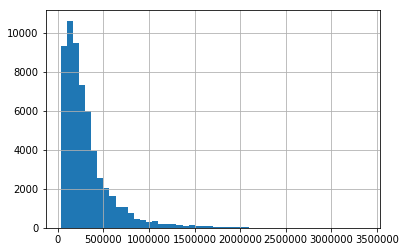

In [15]:
#de la visualización del histograma podemos ver que hay muchos outliers. Es normal porque hay zonas con viviendas con valores extremos
train['price'].hist(bins = 50)

Como vemos los precios están alineados a la izquierda. Para quitar el sesgo hacemos el logaritmo

### Como hemos visto antes los precios están alineados a la izquierda por lo que podemos decir que están sesgados. Vamos a transformarlo en logaritmicos para quitar el sesgo.


In [16]:
#reseteamos el índice
train.reset_index(drop=True, inplace=True)
train["price"] = np.log1p(train["price"])
y = train['price'].reset_index(drop=True)

C:\Users\Lor\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
#vamos a convertir también en logaritmico los precios de test para luego poder compararar con la predicción
test.reset_index(drop=True, inplace=True)
test["price"] = np.log1p(test["price"])
y_t = test['price'].reset_index(drop=True)

C:\Users\Lor\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Después de convertirlos en logaritmicos ahora podemos ver que nuestros precios están centrados, más balanceados

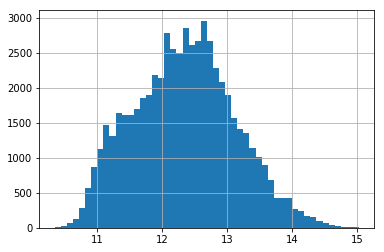

In [18]:
train['price'].hist(bins = 50)

## Vamos a ver la relación entre superficie y unitario

(0, 20000)

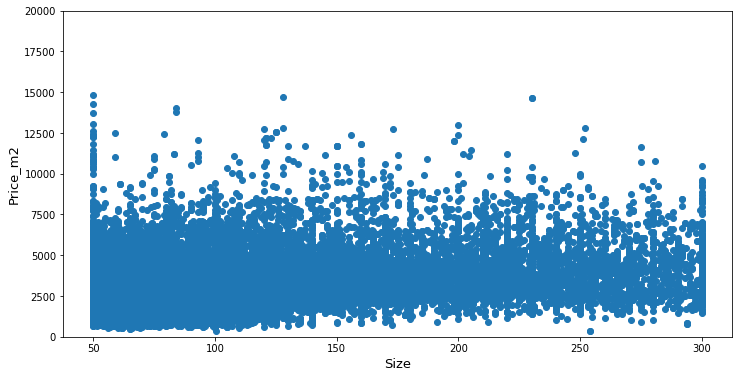

In [19]:
plt.figure(figsize=(12,6))
plt.scatter(x=train['size'], y=train['price_m2'])
plt.xlabel("Size", fontsize=13)
plt.ylabel("Price_m2", fontsize=13)
plt.ylim(0,20000)

## Vemos la correlacion entre variables

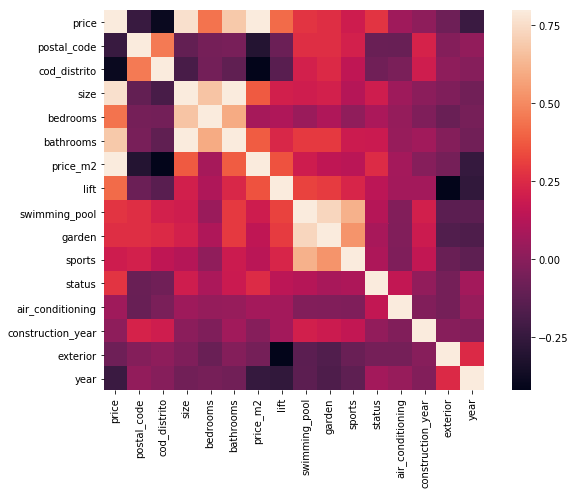

In [20]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(10,7))
sns.heatmap(corrmat, vmax=.8, square=True);

In [21]:
price_house.corr()

,Unnamed: 0,price,postal_code,cod_distrito,size,bedrooms,bathrooms,price_m2,lift,swimming_pool,garden,sports,status,air_conditioning,construction_year,exterior,year
Unnamed: 0,1.000000,-0.026934,0.082303,0.031477,-0.045340,-0.065607,-0.022938,-0.009831,-0.200116,-0.068862,-0.095823,-0.071586,0.053268,0.098966,-0.000539,0.221765,0.906695
price,-0.026934,1.000000,-0.251546,-0.334074,0.813854,0.460444,0.685369,0.767821,0.269189,0.189156,0.170822,0.123359,0.274621,0.109586,-0.016891,-0.033201,-0.072429
postal_code,0.082303,-0.251546,1.000000,0.456655,-0.118090,-0.074494,-0.052182,-0.313748,-0.124131,0.235030,0.231053,0.199064,-0.083115,-0.085734,0.170329,0.018871,0.075053
cod_distrito,0.031477,-0.334074,0.456655,1.000000,-0.180083,-0.065143,-0.112823,-0.442072,-0.142092,0.199281,0.231370,0.147438,-0.064209,-0.037956,0.152941,0.044637,0.010138
size,-0.045340,0.813854,-0.118090,-0.180083,1.000000,0.688146,0.802769,0.365269,0.211895,0.208928,0.227069,0.129368,0.219386,0.068337,0.008707,-0.027216,-0.057977
bedrooms,-0.065607,0.460444,-0.074494,-0.065143,0.688146,1.000000,0.614083,0.084218,0.120118,0.063368,0.120857,0.033158,0.112968,0.037566,-0.016082,-0.087253,-0.067831
bathrooms,-0.022938,0.685369,-0.052182,-0.112823,0.802769,0.614083,1.000000,0.368465,0.234219,0.297780,0.304325,0.191274,0.198952,0.058841,0.049012,-0.016599,-0.045145
price_m2,-0.009831,0.767821,-0.313748,-0.442072,0.365269,0.084218,0.368465,1.000000,0.336059,0.178204,0.133271,0.122964,0.273578,0.122836,-0.025499,-0.055709,-0.095883
lift,-0.200116,0.269189,-0.124131,-0.142092,0.211895,0.120118,0.234219,0.336059,1.000000,0.328576,0.311854,0.233298,0.161356,0.107489,0.026769,-0.443587,-0.251640
swimming_pool,-0.068862,0.189156,0.235030,0.199281,0.208928,0.063368,0.297780,0.178204,0.328576,1.000000,0.731338,0.612210,0.131534,0.026829,0.134831,-0.145456,-0.108657


Observamos que en el precio de la vivienda las variables que más influyen son size (0,81), bathrooms (0,68), bedrooms(0,46) y en menor medida status (0,27), lift(0,26) y swimming pool (0,17). El resto de variables no tienen relevancia e incluso algunas presentan correlaciones negativas. Muy destacable es que tanto el distrito como el código postal tienen una correlación negativa. Aun así vamos a mantener ambos ya que lo necesitaremos posteriormente para poder extraer el unitario por distrito, objetivo de este estudio.

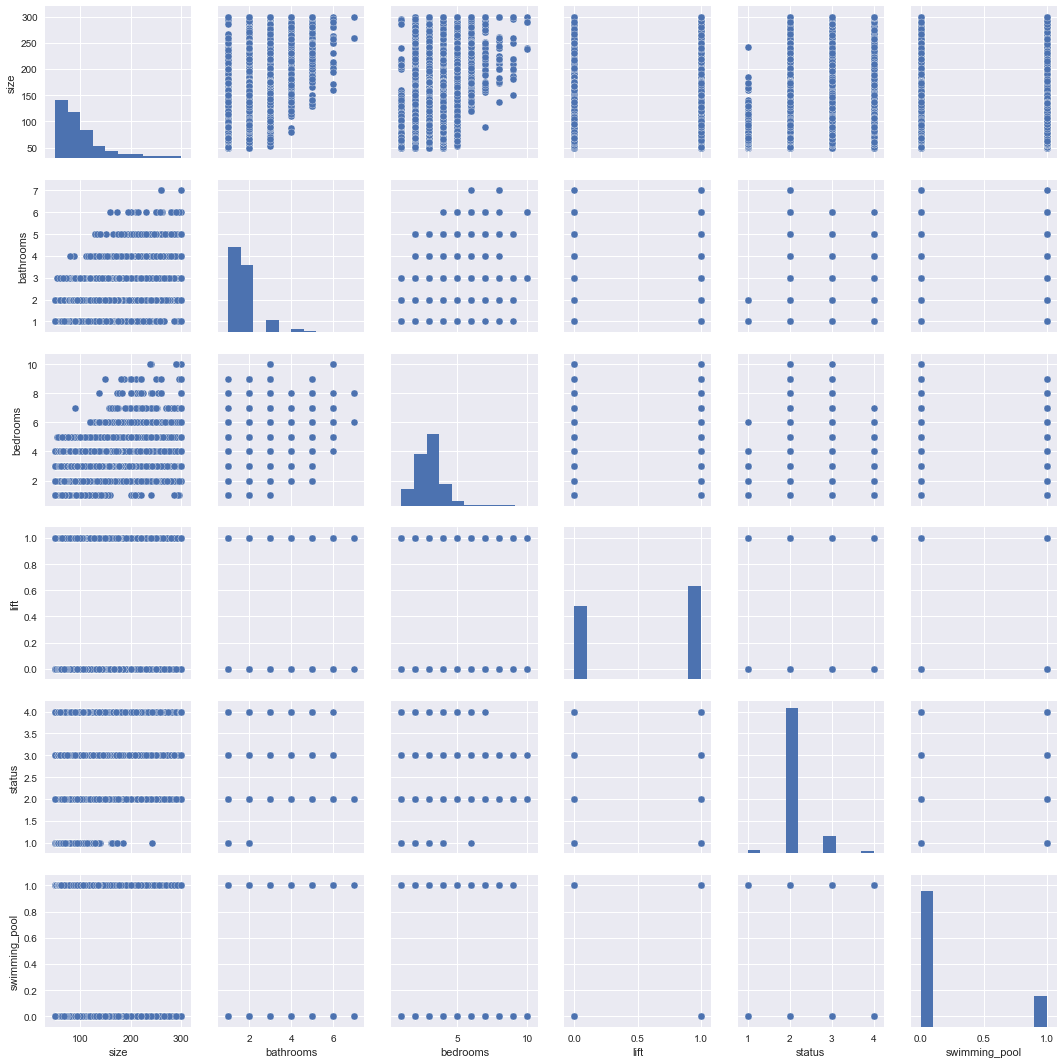

In [22]:
#scatterplot de las columnas más influyentes
sns.set()
cols = ['size', 'bathrooms', 'bedrooms', 'lift', 'status', 'swimming_pool']
sns.pairplot(train[cols], size = 2.5)
plt.show();

## Vamos a analizar ahora los outliers

#### Analizamos la superficie de las viviendas

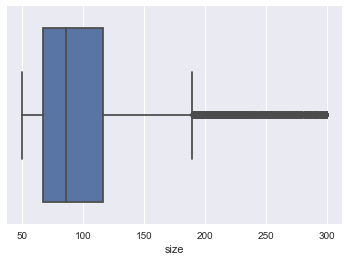

In [23]:
sns.boxplot(x=train['size'])

Con este boxplot vemos que por encima de aprox 175m² estaríamos hablando de outliers.
No obstante, no descartaremos estos valores porque consideramos que deben formar parte de los datos train ya que sí existen inmuebles de ese tipo.

#### Analizamos el unitario (€/m²) de las viviendas

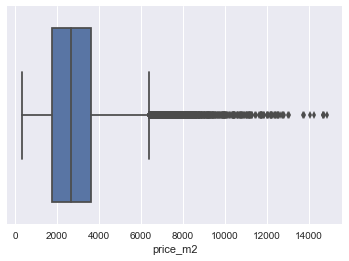

In [24]:
sns.boxplot(x=train['price_m2'])

Se observa que hay valores muy por encima de la "normalidad" (outliers) 
Más que de outliers aquí hablamos de errores porque en la extracción de los datos el volcado de la superficie es incorrecta.
Veremos más adelante como tratar esta información

#### Analizamos el precio de las viviendas

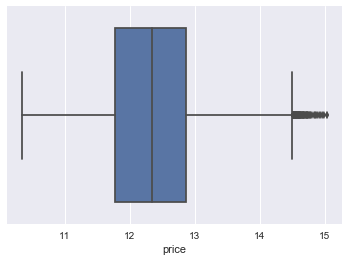

In [25]:
sns.boxplot(x=train['price'])

Después de la conversión en logaritmico vemos que existen outliers por encima del 14,5 aprox. Veremos como tratarlos a continuación.

In [26]:
#quitamos outliers

train_wout = train [(train['price'] < 14.00) & (train ['size'] < 175.00) & (train ['price_m2'] < 6000.00)]
test_wout = test [(test['price'] < 14.00) & (test ['size'] < 175.00) & (test ['price_m2'] < 6000.00)]

In [27]:
train_wout.shape

(52278, 17)

In [28]:
test_wout.shape

(15175, 17)

## Detección de outliers. Ver más adelante si los tratamos de momento se queda como está

## Feature Selection para seleccionar las variables para el modelo. De momento se queda seleccionando a mano las features
https://www.kaggle.com/nafisur/house-price-prediction-from-bangladesh



In [29]:
train.columns

Index(['Fecha', 'price', 'postal_code', 'cod_distrito', 'size', 'bedrooms',
       'bathrooms', 'price_m2', 'lift', 'swimming_pool', 'garden', 'sports',
       'status', 'air_conditioning', 'construction_year', 'exterior', 'year'],
      dtype='object')

In [30]:
X_train = train_wout[['size', 'bedrooms','bathrooms', 'lift', 'swimming_pool', 'garden', 'sports','status','air_conditioning']]
y_train = train_wout[['price']]

In [31]:
X_test = test[['size', 'bedrooms','bathrooms', 'lift', 'swimming_pool', 'garden', 'sports','status','air_conditioning']]
y_test = test[['price']]

In [32]:
X_train.shape

(52278, 9)

In [33]:
X_test.shape

(17246, 9)

In [34]:
y_train.shape

(52278, 1)

In [35]:
y_test.shape

(17246, 1)

## Desarrollando el modelo

### Validación cruzada

In [36]:
# Evaluamos métricas. CON RMSE
num_folds = 10
scoring = "r2"
# Score para cada algoritmo
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RFR', RandomForestRegressor()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold,    scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(),   cv_results.std())
    print(msg)

LR: 0.533455 (0.171084)
LASSO: 0.392423 (0.226218)
EN: 0.393956 (0.228634)
KNN: 0.489166 (0.226330)
CART: 0.518190 (0.196638)


C:\Users\Lor\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Lor\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Lor\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Lor\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed whe

RFR: 0.546687 (0.197391)


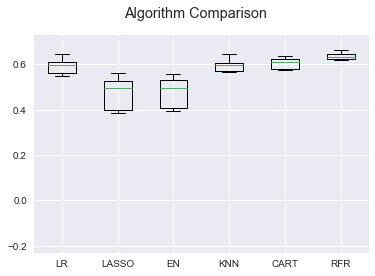

In [37]:
# Compare Algorithms
from matplotlib import pyplot

fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### MIRAR MODELADO DE RANDOMFOREST

https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [38]:
X_train.shape

(52278, 9)

In [39]:
X_test.shape

(17246, 9)

In [40]:
y_train.shape

(52278, 1)

In [41]:
y_test.shape

(17246, 1)

In [42]:
# Vamos a utilizar en el RF 1000 árboles
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Entreno el modelo con los datos de train que son anteriores a 2018
rf.fit(X_train, y_train);

C:\Users\Lor\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [43]:
# Ahora hacemos la predicción sobre el X_test que tiene menos datos porque es de 2018 a la actualidad
predictions = rf.predict(X_test)

In [44]:
#resultado de mi predicción con RandomForest
predictions

array([11.55421408, 11.3887792 , 11.35470582, ..., 12.0966817 ,
       12.29830319, 12.27323809])

In [45]:
#Convierto la predicción en un dataframe
prediccion=pd.DataFrame(predictions, columns=['prediccion'])
prediccion

,prediccion
0,11.554214
1,11.388779
2,11.354706
3,12.734454
4,13.077729
5,13.086558
6,13.270947
7,13.270265
8,13.397205
9,13.346148


In [49]:
prediccion.shape

(17246, 1)

In [50]:
y_test.shape

(17246, 1)

In [51]:
unido =pd.concat([y_test, prediccion], axis =1, sort = True)
unido

,price,prediccion
0,11.251578,11.554214
1,11.270867,11.388779
2,11.274046,11.354706
3,12.644331,12.734454
4,13.331002,13.077729
5,13.301346,13.086558
6,13.285844,13.270947
7,13.137453,13.270265
8,14.310207,13.397205
9,14.731802,13.346148


In [52]:
#ahora quiero comparar predicción con y_test
#errors = abs(int(prediccion)- int(y_test)
#errors

In [53]:
mean_absolute_error(y_test, prediccion)


0.35427824839612077

In [54]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, prediccion)  


0.21964004240080046

In [55]:
y_test

,price
0,11.251578
1,11.270867
2,11.274046
3,12.644331
4,13.331002
5,13.301346
6,13.285844
7,13.137453
8,14.310207
9,14.731802


In [57]:
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_test, prediccion))

0.4686577028074973

# para revertir el np.log1p . IMPORTANTE!!!


In [58]:
prediccion

,prediccion
0,11.554214
1,11.388779
2,11.354706
3,12.734454
4,13.077729
5,13.086558
6,13.270947
7,13.270265
8,13.397205
9,13.346148


In [59]:
y_test.shape

(17246, 1)

In [60]:
y_t.shape

(17246,)

In [61]:
#revierto el log
y_prediccion = np.expm1(y_test)
back_prediccion = np.expm1(prediccion)

In [62]:
unido_sinlog =pd.concat([y_prediccion, back_prediccion], axis =1, sort = True)
unido_sinlog ['error'] = unido_sinlog['price']-unido_sinlog['prediccion']
unido_sinlog

,price,prediccion,error
0,77000.30,104214.284779,-2.721398e+04
1,78500.06,88324.064494,-9.824004e+03
2,78750.00,85365.225958,-6.615226e+03
3,310000.00,339235.800227,-2.923580e+04
4,615999.00,478172.614493,1.378264e+05
5,597999.00,482413.100901,1.155859e+05
6,588800.24,580093.684810,8.706555e+03
7,507601.22,579698.597493,-7.209738e+04
8,1640000.00,658160.160659,9.818398e+05
9,2500000.00,625400.049124,1.874600e+06


In [63]:

#hay mucha dispersion de valores...parece que va a ser mejor quitar los outliers
unido_sinlog.describe()

,price,prediccion,error
count,1.724600e+04,17246.000000,1.724600e+04
mean,3.450175e+05,254900.111471,9.011742e+04
std,3.123056e+05,159182.633264,2.181360e+05
min,4.171074e+04,38080.818987,-4.391737e+05
25%,1.425000e+05,125812.088641,-7.201445e+03
50%,2.460251e+05,209933.477295,3.338755e+04
75%,4.300000e+05,337780.146790,1.309809e+05
max,3.849998e+06,834645.822294,3.211379e+06


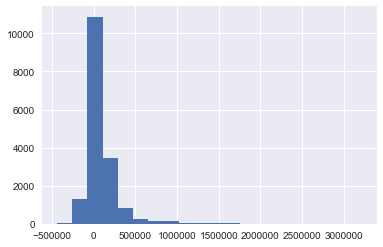

In [64]:
#distribución de mis errores en la predicción
unido_sinlog ['error'].hist(bins = 20)